In [1]:
# SweBERT imports

import torch
import tensorflow as tf
from transformers import BertTokenizer, BertModel, TFBertModel, BertForMaskedLM 
from tokenizers import BertWordPieceTokenizer

import warnings; warnings.filterwarnings('ignore')

/home/erko/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Sentence transformer imports

from sentence_transformers import SentenceTransformer, models

In [14]:
import os
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup

<p>Initialize a PyTorch model:</p>

In [15]:
pretrained_model_name = 'af-ai-center/bert-large-swedish-uncased'
model_directory = "bert-base-swedish-uncased"
# PyTorch
model = SentenceTransformer(model_directory)
# TensorFlow
#model = TFBertModel.from_pretrained(model_directory)

No sentence-transformers model found with name bert-base-swedish-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at bert-base-swedish-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<p> Data set: </p>

In [16]:
# The directory where data is located
data_dir = "test_data/22_23/"
data = []
for file in os.listdir(data_dir):
    if file.endswith(".txt"):
        with open(data_dir+file,"r") as f:
            data.append([])
            for line in f.readlines():
                data[-1].append(line)

data = np.array(data)

# Print first and last data points
#print(data[0])
#print(data[-1])

# Get only speeches
speeches = data[:,1]

In [7]:
# Count Herr/Fru talman amounts

talman_counts = [s.count("Fru talman!")+s.count("Herr talman!") for s in speeches]
print(sum(talman_counts)/len(talman_counts))

1.361302276336686


<p>Divide speeches into paragraphs:</p>

In [6]:
paragraphs = []
for s in speeches:
    soup = BeautifulSoup(s, 'html.parser')
    ps = soup.find_all("p")
    for p in ps:
        paragraphs.append(p)

print(len(paragraphs))

# Use only a few sentences
# sentence_training_set = sentences[:50000]

Vi talar här om huvudstaden, med allt vad det innebär
Rent principiellt anser jag inte heller att en kommun ska få stifta regler som de här
Självklart ska vi ha kommunalt självstyre, men detta självstyre har aldrig varit absolut
Vi har sett det i till exempel immigrationsfrågan, där kommuner fick rätta sig efter nationella intressen - detta sagt oavsett vad jag personligen tycker om den lagen.
Vi kan i förlängningen föreställa oss kommuner som förbjuder vägar, tågtrafik eller elledningar
Det är inte bara Stockholms stad som är beroende av kommunikationerna i staden, utan det finns en massa människor i till exempel Stockholms län som arbetar inne i staden
En stor del av dessa är beroende av bil för att ta sig till arbetet
I deras hemkommuner, som till exempel min egen hemkommun Botkyrka, saknas laddstolpar för elbilar
Så är det trots att jag själv har motionerat om detta i min hemkommun
Ändå förutsätts dessa människor i kranskommunerna skaffa sig svindyra elbilar - elbilar som många int

<p>Use only a few of the speeches:</p>

In [9]:
train_set = speeches[:1000]

<p>Create word embedding model:</p>

In [7]:
# Code from https://www.sbert.net/docs/training/overview.html

word_embedding_model = models.Transformer(pretrained_model_name, max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of the model checkpoint at af-ai-center/bert-base-swedish-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<p>Embeddings:</p>

In [1]:
#embeddings = model.encode(train_set, show_progress_bar=True)
embeddings = model.encode(sentence_training_set, show_progress_bar=True)

NameError: name 'model' is not defined

In [20]:
# View embeddings

print(embeddings)

[[-0.41236892 -0.06983794 -1.1565996  ... -0.6425186   0.42941743
  -0.83314085]
 [-0.5928931  -0.6694788  -0.677221   ... -1.1357127   1.2073548
  -0.56740004]
 [-0.17447756 -0.7885041   0.16059685 ... -0.8057421   0.4189502
  -0.88015974]
 ...
 [-1.2694623  -0.23539096  0.449709   ... -0.89313495  0.32131326
  -0.8652348 ]
 [-0.18670663 -0.50414455  0.21535936 ... -1.2162182   0.05784209
  -0.5328909 ]
 [-0.47660092 -0.69764924  0.15982357 ... -0.781184    0.5756413
  -1.3813131 ]]


<h3>Clustering</h3>
<p>We use UMAP to lower dimensionality before clustering.</p>

In [24]:
import umap

# From Grootendorst's article

umap_embeddings = umap.UMAP(n_neighbors=15, n_components=15, metric='cosine').fit_transform(embeddings)

<p>Clustering using HDBSCAN:</p>

In [41]:
import hdbscan

# From Grootendorst

#cluster = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)

# Using the embeddings directly:

cluster = hdbscan.HDBSCAN(min_cluster_size=60, min_samples=1, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings)


<p>Vizualize clusters:</p>

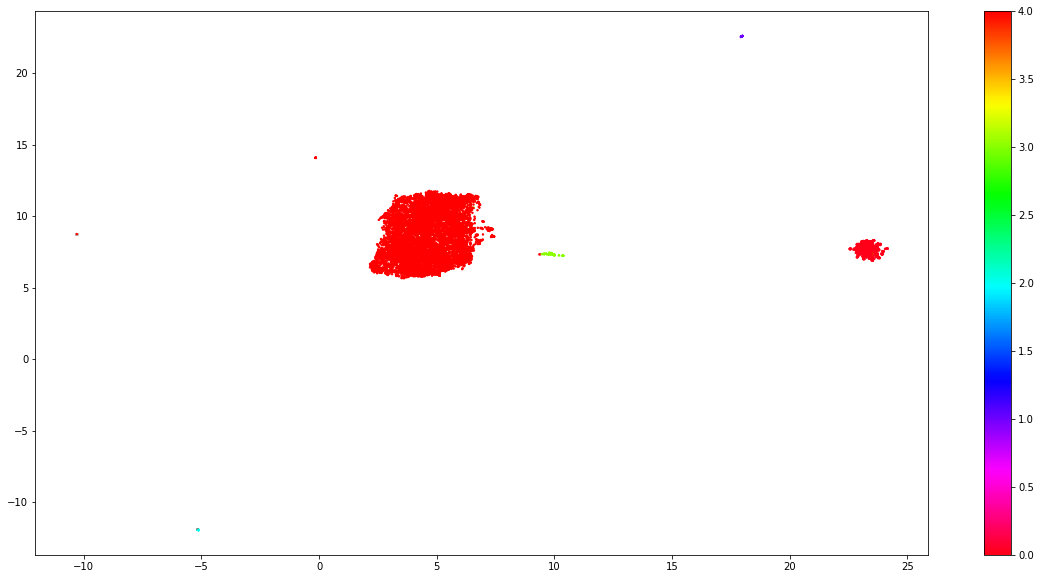

In [42]:
# From Grootendorst

import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=2)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=2, cmap='hsv_r')
plt.colorbar()

<h3>Topic creation</h3>
<p>First, try using Grootendorst's code:</p>

In [27]:
# From Grootendorst's example:
docs_df = pd.DataFrame(sentence_training_set, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=None).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(sentence_training_set))

In [37]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=50)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
5,4,8703
1,0,1037
2,1,88
4,3,79
3,2,65
0,-1,28


In [38]:
print(top_n_words[4][20:40])
print(top_n_words[0][0:20])
print(top_n_words[1][0:20])
print(top_n_words[3][0:20])

[('ska', 0.01617684626621582), ('kan', 0.013264353289559544), ('talman', 0.01300442915633343), ('men', 0.012697493909361951), ('också', 0.012205056166710417), ('detta', 0.012059863725832409), ('här', 0.011739677571318458), ('kommer', 0.011548156274122855), ('sverige', 0.01136523532376773), ('så', 0.011050507179003749), ('när', 0.010667248162694822), ('regeringen', 0.010247191192111857), ('nu', 0.009942271089867973), ('sig', 0.009510966131430796), ('finns', 0.009504447591160805), ('från', 0.009277066454192722), ('vill', 0.009119744583296141), ('vara', 0.00888479790170303), ('var', 0.008761766927796642), ('herr', 0.008659704381044549)]
[('frågestund', 6.907755278982137), ('övärlden', 0.0), ('hemvist', 0.0), ('hetsjakt', 0.0), ('hetsig', 0.0), ('heter', 0.0), ('heta', 0.0), ('het', 0.0), ('hesari', 0.0), ('herrey', 0.0), ('herrar', 0.0), ('herr', 0.0), ('hepp', 0.0), ('hennes', 0.0), ('henne', 0.0), ('hemtjänst', 0.0), ('hette', 0.0), ('hemstad', 0.0), ('hemskt', 0.0), ('hemskickad', 0.0)